# Cash Demand Forecasting in ATM Using Machine Learning

# Downloading the Required Libraries

In [3]:
!pip install catboost --quiet
!pip install shap --quiet

     |████████████████████████████████| 76.6 MB 84 kB/s 
     |████████████████████████████████| 569 kB 3.8 MB/s 


# Importing the Libraries

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import VotingRegressor

import shap
from xgboost import XGBRegressor
from catboost import CatBoostRegressor

from fbprophet import Prophet

In [5]:
df = pd.read_csv(URL)
df.head()

,Unnamed: 0,atm_name,weekday,festival_religion,working_day,holiday_sequence,trans_date_set,trans_month,trans_year,prevweek_mean,total_amount_withdrawn
0,11,Mount Road ATM,MONDAY,NH,W,WWW,1,1,2011,648600,897100
1,16,Mount Road ATM,TUESDAY,NH,W,WWW,1,1,2011,648600,826000
2,21,Mount Road ATM,WEDNESDAY,NH,W,WWW,1,1,2011,648600,754400
3,26,Mount Road ATM,THURSDAY,NH,W,WWW,2,1,2011,648600,834200
4,31,Mount Road ATM,FRIDAY,NH,W,WWW,2,1,2011,648600,575300


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2244 entries, 0 to 2243
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   Unnamed: 0              2244 non-null   int64 
 1   atm_name                2244 non-null   object
 2   weekday                 2244 non-null   object
 3   festival_religion       2244 non-null   object
 4   working_day             2244 non-null   object
 5   holiday_sequence        2244 non-null   object
 6   trans_date_set          2244 non-null   int64 
 7   trans_month             2244 non-null   int64 
 8   trans_year              2244 non-null   int64 
 9   prevweek_mean           2244 non-null   int64 
 10  total_amount_withdrawn  2244 non-null   int64 
dtypes: int64(6), object(5)
memory usage: 193.0+ KB


In [7]:
df.describe()

,Unnamed: 0,trans_date_set,trans_month,trans_year,prevweek_mean,total_amount_withdrawn
count,2244.000000,2244.000000,2244.000000,2244.000000,2.244000e+03,2.244000e+03
mean,5706.037433,3.557932,6.313280,2013.710784,5.150901e+05,5.157175e+05
std,3348.296502,1.760703,3.257336,1.920082,1.935272e+05,2.551791e+05
min,11.000000,1.000000,1.000000,2011.000000,1.800000e+03,1.000000e+02
25%,2816.750000,2.000000,4.000000,2012.000000,4.197290e+05,3.494750e+05
50%,5664.500000,4.000000,6.000000,2014.000000,5.403860e+05,5.141000e+05
75%,8447.250000,5.000000,9.000000,2015.000000,6.378000e+05,6.849250e+05
max,11585.000000,7.000000,12.000000,2017.000000,1.006829e+06,1.410700e+06


In [8]:
# Adding Date Column to DataFrame
date_cols = ['trans_year', 'trans_month','trans_date_set']
df['date'] = df[date_cols].apply(lambda x: '-'.join(x.values.astype(str)), axis="columns")
df['date'] = pd.to_datetime(df['date'])

# Set the Index to date column
df = df.set_index('date')
df.head()

,Unnamed: 0,atm_name,weekday,festival_religion,working_day,holiday_sequence,trans_date_set,trans_month,trans_year,prevweek_mean,total_amount_withdrawn
date,,,,,,,,,,,
2011-01-01,11,Mount Road ATM,MONDAY,NH,W,WWW,1,1,2011,648600,897100
2011-01-01,16,Mount Road ATM,TUESDAY,NH,W,WWW,1,1,2011,648600,826000
2011-01-01,21,Mount Road ATM,WEDNESDAY,NH,W,WWW,1,1,2011,648600,754400
2011-01-02,26,Mount Road ATM,THURSDAY,NH,W,WWW,2,1,2011,648600,834200
2011-01-02,31,Mount Road ATM,FRIDAY,NH,W,WWW,2,1,2011,648600,575300


# Explonatory Data Analysis

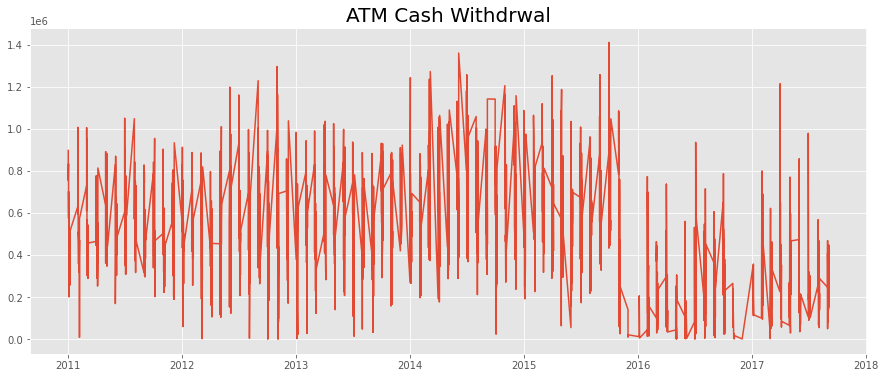

In [9]:
plt.figure(figsize = (15,6))
plt.style.use('ggplot')
plt.plot(df['total_amount_withdrawn'])
plt.title("ATM Cash Withdrwal", fontsize = 20)
plt.show()

## Distribution plot of Target Variable

count       2244.0
mean      515717.0
std       255179.0
min          100.0
25%       349475.0
50%       514100.0
75%       684925.0
max      1410700.0
Name: total_amount_withdrawn, dtype: float64

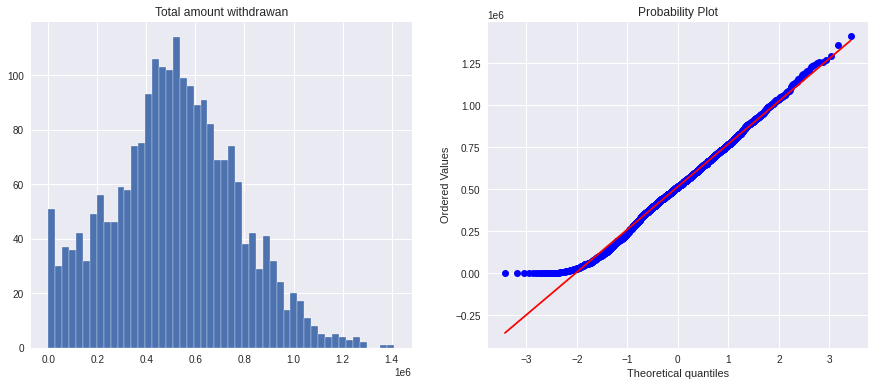

In [10]:
plt.figure(figsize=(15,6))
plt.style.use("seaborn")
plt.subplot(1,2,1)
df['total_amount_withdrawn'].hist(bins=50, edgecolor="white")
plt.title('Total amount withdrawan')
plt.subplot(1,2,2)
stats.probplot(df['total_amount_withdrawn'], plot=plt);
df['total_amount_withdrawn'].describe().T.round()

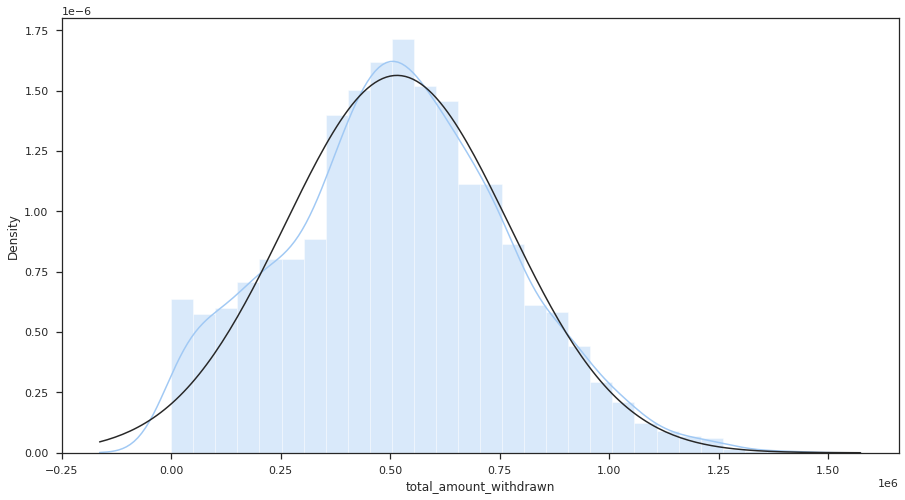

In [11]:
plt.figure(figsize = (15,8))
sns.set_theme(style="ticks", palette="pastel")
sns.distplot(df['total_amount_withdrawn'],fit=stats.norm)
plt.show()

## Correlation Matrix

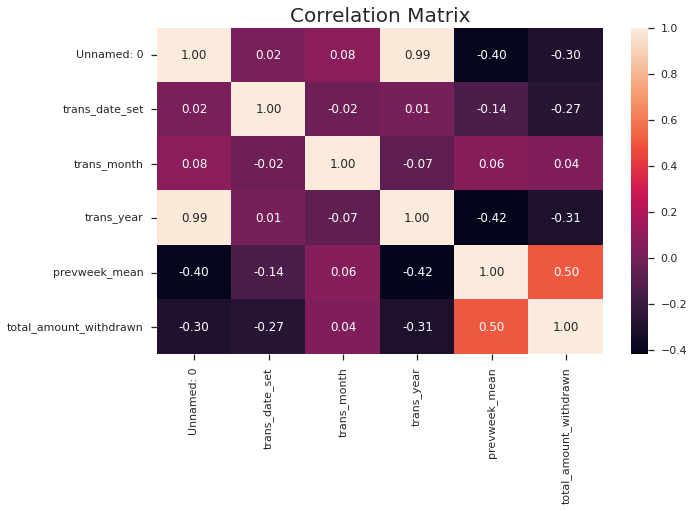

In [12]:
plt.figure(figsize=(10,6))
sns.heatmap(df.corr(),annot=True,fmt=".2f")
plt.title("Correlation Matrix", fontsize = 20)
plt.show()

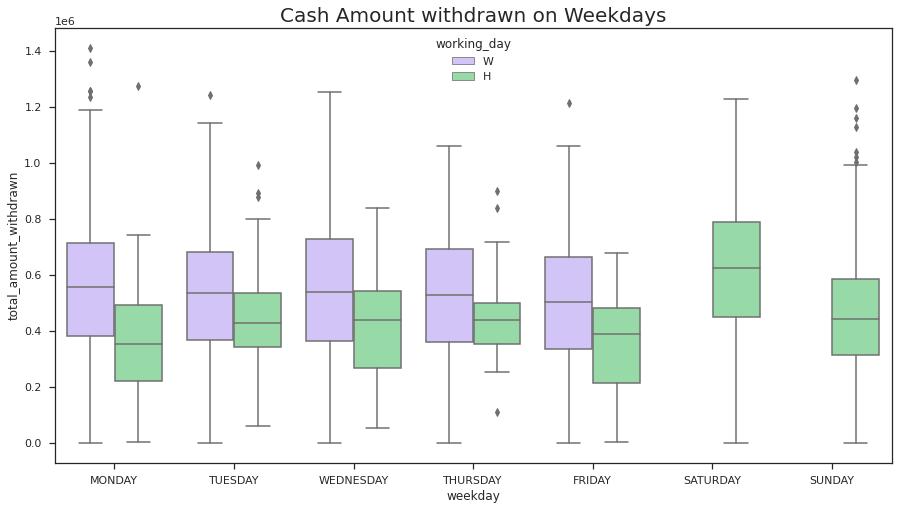

In [13]:
sns.set_theme(style="ticks", palette="pastel")
plt.figure(figsize = (15,8))
sns.boxplot(x="weekday", y="total_amount_withdrawn", hue="working_day", palette=["m", "g"], data=df)
plt.title("Cash Amount withdrawn on Weekdays", fontsize = 20)
plt.show()

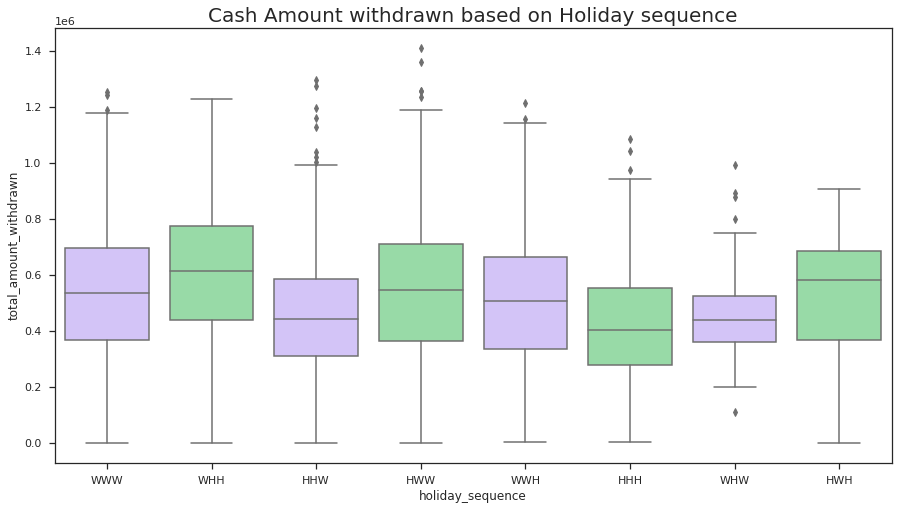

In [14]:
sns.set_theme(style="ticks", palette="pastel")
plt.figure(figsize = (15,8))
sns.boxplot(x="holiday_sequence", y="total_amount_withdrawn", palette=["m", "g"], data=df)
plt.title("Cash Amount withdrawn based on Holiday sequence", fontsize = 20)
plt.show()

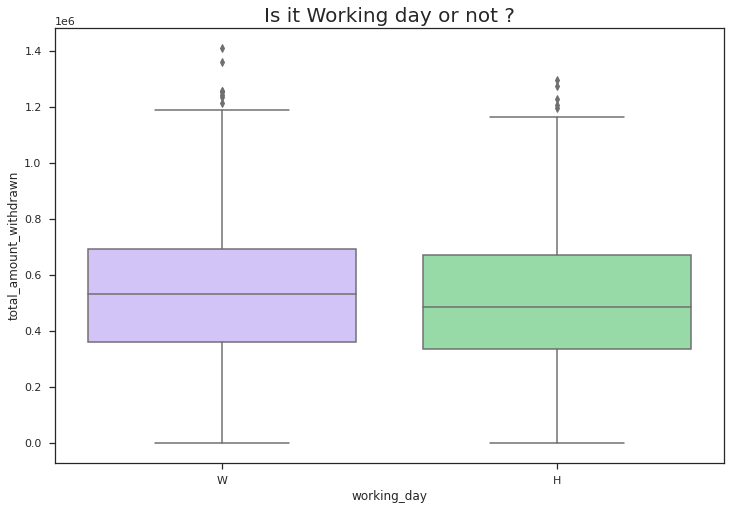

In [15]:
sns.set_theme(style="ticks", palette="pastel")
plt.figure(figsize = (12,8))
sns.boxplot(x="working_day", y="total_amount_withdrawn", palette=["m", "g"], data=df)
plt.title("Is it Working day or not ?", fontsize = 20)
plt.show()

# Data Preprocessing

In [16]:
FEATURES = df.copy()

# Extracting numerical and Categorical Columns
NUMERIC_COLS = df.select_dtypes(include=np.number).columns.tolist()
CATEGORICAL_COLS = df.select_dtypes(include = 'object').columns.tolist()[1:]

NUMERIC_DATA = df[NUMERIC_COLS]
CATEGORICAL_DATA = df[CATEGORICAL_COLS]

# One Hot Encoding the Categorical Variables
CATEGORICAL_DATA = pd.get_dummies(CATEGORICAL_DATA)

# Concating the two dataframe
FEATURES = pd.concat([NUMERIC_DATA, CATEGORICAL_DATA], axis = 1)
FEATURES.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2244 entries, 2011-01-01 to 2017-09-06
Data columns (total 28 columns):
 #   Column                  Non-Null Count  Dtype
---  ------                  --------------  -----
 0   Unnamed: 0              2244 non-null   int64
 1   trans_date_set          2244 non-null   int64
 2   trans_month             2244 non-null   int64
 3   trans_year              2244 non-null   int64
 4   prevweek_mean           2244 non-null   int64
 5   total_amount_withdrawn  2244 non-null   int64
 6   weekday_FRIDAY          2244 non-null   uint8
 7   weekday_MONDAY          2244 non-null   uint8
 8   weekday_SATURDAY        2244 non-null   uint8
 9   weekday_SUNDAY          2244 non-null   uint8
 10  weekday_THURSDAY        2244 non-null   uint8
 11  weekday_TUESDAY         2244 non-null   uint8
 12  weekday_WEDNESDAY       2244 non-null   uint8
 13  festival_religion_C     2244 non-null   uint8
 14  festival_religion_H     2244 non-null   uint8
 15  fes

In [17]:
X = FEATURES.copy().drop(columns = ['total_amount_withdrawn'])
y = FEATURES['total_amount_withdrawn'].copy()

# Splitting the Data into Train and Test Set

Here, we set shuffle to `False` because we do not want our model to learn from future data. So what it does is it split first 80% observations to train and next 20% to test

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle = False, test_size = 0.05, random_state = 1)
print("The no. of observation in X_train are", X_train.shape[0])
print("The no. of observation in X_test are:",X_test.shape[0])

The no. of observation in X_train are 2131
The no. of observation in X_test are: 113


In [19]:
y_test

date
2017-06-01    398600
2017-06-02    575500
2017-06-02    856400
2017-06-02    647900
2017-06-02    258900
               ...  
2017-09-05    447400
2017-09-06    153800
2017-09-06    167100
2017-09-06    317400
2017-09-06    305100
Name: total_amount_withdrawn, Length: 113, dtype: int64

# Model Building

In [20]:
# Function to Analyze The Model Performance
def analyze_model(Model_name, Model_Prediction, y_test = y_test):
  analyze_df = pd.DataFrame({Model_name: np.round(Model_Prediction, decimals = 0), 'True_Values': y_test})
  analyze_df['WeekDay'] = analyze_df.index.day_name()
  analyze_df['%Age Error'] =  np.round(((Model_Prediction-y_test)/y_test*100), decimals = 0)
  print(f"R2 Score for {Model_name} model is:", r2_score(y_test, Model_Prediction))
  print(f"Mean Absolute Error for {Model_name} model is:", np.round(mean_absolute_error(y_test, Model_Prediction), decimals = 0))
  print(f"Accuracy:", y_test.mean()/Model_Prediction.mean())
  return analyze_df.sample(10)

## Linear Regression

In [21]:
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
lr_pred = lr_model.predict(X_test)

In [22]:
analyze_model("Linear Regression", lr_pred)

R2 Score for Linear Regression model is: -0.10331933304232477
Mean Absolute Error for Linear Regression model is: 120854.0
Accuracy: 1.1751957512216065


,Linear Regression,True_Values,WeekDay,%Age Error
date,,,,
2017-06-04,153096.0,138000,Sunday,11.0
2017-09-01,328527.0,384700,Friday,-15.0
2017-07-05,207535.0,211800,Wednesday,-2.0
2017-08-04,182293.0,105200,Friday,73.0
2017-06-05,94452.0,72500,Monday,30.0
2017-09-05,144902.0,337100,Tuesday,-57.0
2017-08-02,295871.0,292300,Wednesday,1.0
2017-07-01,308288.0,104400,Saturday,195.0
2017-08-05,184886.0,121500,Saturday,52.0


## Decision Tree

In [23]:
dt_model = DecisionTreeRegressor()
dt_model.fit(X_train, y_train)
dt_pred = dt_model.predict(X_test)

In [24]:
analyze_model("Decision Tree", dt_pred)

R2 Score for Decision Tree model is: -1.0403896304616782
Mean Absolute Error for Decision Tree model is: 178694.0
Accuracy: 0.7552987198698229


,Decision Tree,True_Values,WeekDay,%Age Error
date,,,,
2017-07-02,181600.0,184500,Sunday,-2.0
2017-06-02,449100.0,124900,Friday,260.0
2017-07-05,222000.0,163100,Wednesday,36.0
2017-08-02,473000.0,378600,Wednesday,25.0
2017-08-04,466800.0,105200,Friday,344.0
2017-08-01,449100.0,225400,Tuesday,99.0
2017-06-04,365900.0,138000,Sunday,165.0
2017-08-04,60000.0,376700,Friday,-84.0
2017-07-03,473000.0,90300,Monday,424.0


## Random Forest

In [25]:
rf_model = RandomForestRegressor(n_estimators = 100, max_depth = 5)
rf_model.fit(X_train, y_train)
rf_pred = rf_model.predict(X_test)

In [26]:
analyze_model("Random Forest", rf_pred)

R2 Score for Random Forest model is: 0.025543157195492494
Mean Absolute Error for Random Forest model is: 119573.0
Accuracy: 0.8692686695063346


,Random Forest,True_Values,WeekDay,%Age Error
date,,,,
2017-09-02,253845.0,82700,Saturday,207.0
2017-07-06,244081.0,230700,Thursday,6.0
2017-07-06,222447.0,195200,Thursday,14.0
2017-07-01,314344.0,414700,Saturday,-24.0
2017-07-03,310783.0,90300,Monday,244.0
2017-09-06,271873.0,167100,Wednesday,63.0
2017-07-04,273951.0,147900,Tuesday,85.0
2017-06-06,273592.0,214700,Tuesday,27.0
2017-08-04,280192.0,376700,Friday,-26.0


## XGBoost

In [27]:
xgb_model = XGBRegressor(objective = 'reg:squarederror')
xgb_model.fit(X_train, y_train)
xgb_pred = xgb_model.predict(X_test)

In [28]:
analyze_model("XGBoost", xgb_pred)

R2 Score for XGBoost model is: 0.07764137581000874
Mean Absolute Error for XGBoost model is: 115372.0
Accuracy: 0.9012783779511135


,XGBoost,True_Values,WeekDay,%Age Error
date,,,,
2017-09-05,165206.0,182700,Tuesday,-10.0
2017-09-03,269028.0,80500,Sunday,234.0
2017-07-03,330933.0,265700,Monday,25.0
2017-07-05,155122.0,170100,Wednesday,-9.0
2017-09-01,307645.0,384700,Friday,-20.0
2017-08-01,314074.0,255000,Tuesday,23.0
2017-09-02,241683.0,341200,Saturday,-29.0
2017-08-04,260283.0,466900,Friday,-44.0
2017-07-04,245293.0,135000,Tuesday,82.0


In [29]:
xgb_model.feature_importances_

array([0.1358827 , 0.12763433, 0.02174067, 0.        , 0.05030273,
       0.0103267 , 0.00684974, 0.05213656, 0.23522052, 0.01452854,
       0.        , 0.00435428, 0.03508108, 0.014968  , 0.        ,
       0.        , 0.10204306, 0.03154399, 0.        , 0.02467193,
       0.10183282, 0.        , 0.01383517, 0.        , 0.01704713,
       0.        , 0.        ], dtype=float32)

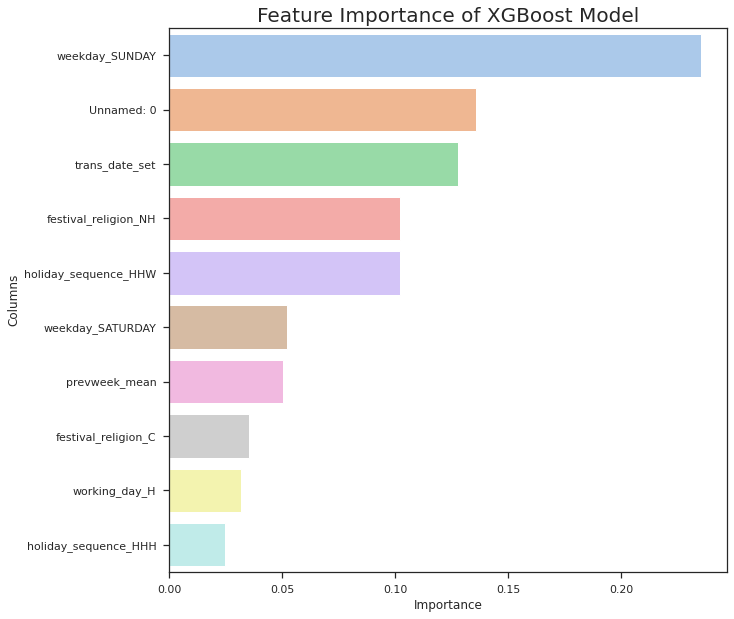

In [30]:
plt.figure(figsize = (10,10))
feature_importance_df = pd.DataFrame({'Columns':X.columns, 'Importance': xgb_model.feature_importances_}).sort_values(by = 'Importance', ascending = False)
sns.barplot(data = feature_importance_df[:10], x = 'Importance', y = 'Columns')
plt.title("Feature Importance of XGBoost Model", fontsize = 20)
plt.show()

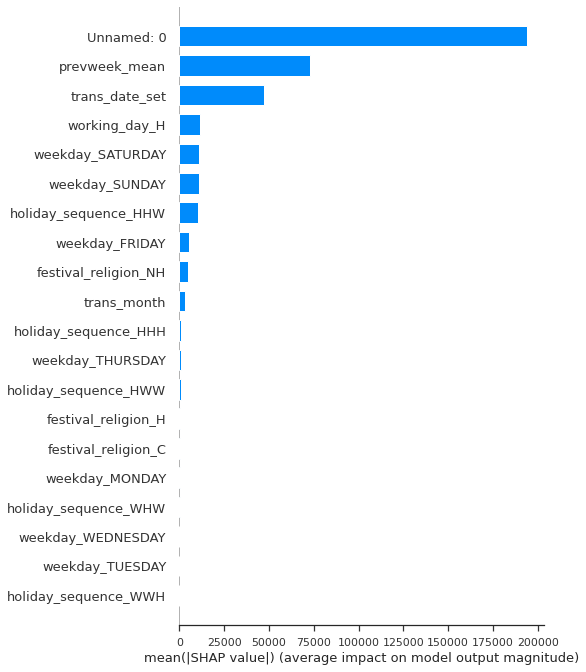

In [31]:
shap_values = shap.TreeExplainer(xgb_model).shap_values(X_test)
shap.summary_plot(shap_values, X_test, plot_type="bar")

## CatBoost

In [32]:
catboost = CatBoostRegressor()
catboost.fit(X_train, y_train, eval_set=[(X_test, y_test)],
       early_stopping_rounds=10, verbose=50,plot=True)
cat_pred = catboost.predict(X_test)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.057343
0:	learn: 244809.4894410	test: 311384.8882293	best: 311384.8882293 (0)	total: 47.5ms	remaining: 47.5s
50:	learn: 169021.8201435	test: 147125.2723660	best: 147125.2723660 (50)	total: 113ms	remaining: 2.1s
100:	learn: 160178.7287613	test: 144346.2137107	best: 144148.1100463 (98)	total: 167ms	remaining: 1.49s
Stopped by overfitting detector  (10 iterations wait)

bestTest = 144148.11
bestIteration = 98

Shrink model to first 99 iterations.


In [33]:
analyze_model('CatBoost', cat_pred)

R2 Score for CatBoost model is: 0.13218428252308845
Mean Absolute Error for CatBoost model is: 109616.0
Accuracy: 0.9086288198019796


,CatBoost,True_Values,WeekDay,%Age Error
date,,,,
2017-07-05,244238.0,211800,Wednesday,15.0
2017-06-06,226299.0,214700,Tuesday,5.0
2017-09-02,340261.0,161500,Saturday,111.0
2017-08-04,239975.0,105200,Friday,128.0
2017-07-05,244867.0,190500,Wednesday,29.0
2017-09-04,241149.0,398600,Monday,-40.0
2017-06-06,221690.0,211700,Tuesday,5.0
2017-06-02,366069.0,647900,Friday,-43.0
2017-09-04,240726.0,308400,Monday,-22.0


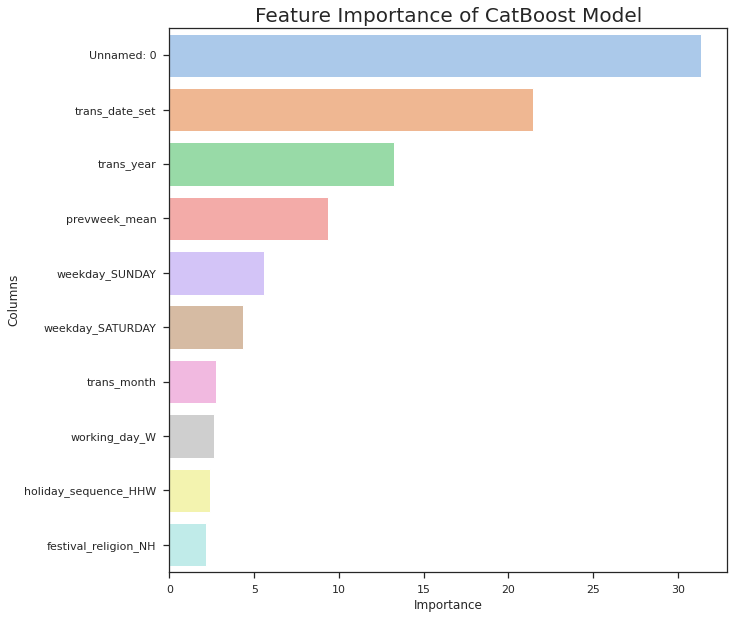

In [34]:
plt.figure(figsize = (10,10))
feature_importance_df = pd.DataFrame({'Columns':X.columns, 'Importance': catboost.feature_importances_}).sort_values(by = 'Importance', ascending = False)
sns.barplot(data = feature_importance_df[:10], x = 'Importance', y = 'Columns')
plt.title("Feature Importance of CatBoost Model", fontsize = 20)
plt.show()

## FBProphet

In [42]:
# Preparing Data for FBProphet
fb_prophet_data = pd.DataFrame(y_train).copy()
fb_prophet_data['ds'] = fb_prophet_data.index
fb_prophet_data['y'] = fb_prophet_data['total_amount_withdrawn']
del fb_prophet_data['total_amount_withdrawn']
fb_prophet_data.head()

,ds,y
date,,
2011-01-01,2011-01-01,897100
2011-01-01,2011-01-01,826000
2011-01-01,2011-01-01,754400
2011-01-02,2011-01-02,834200
2011-01-02,2011-01-02,575300


In [46]:
y_test.tail()

date
2017-09-05    447400
2017-09-06    153800
2017-09-06    167100
2017-09-06    317400
2017-09-06    305100
Name: total_amount_withdrawn, dtype: int64

In [ ]:
fb_prophet = Prophet()
fb_prophet.fit(fb_prophet_data)

In [51]:
fb_prophet_test = pd.DataFrame({'ds': y_test.index})
prophet_pred = fb_prophet.predict(fb_prophet_test)

In [61]:
analyze_model("FB Prophet", np.array(prophet_pred['yhat']))

R2 Score for FB Prophet model is: -0.5626418353859934
Mean Absolute Error for FB Prophet model is: 135573.0
Accuracy: 1.7127558903819742


,FB Prophet,True_Values,WeekDay,%Age Error
date,,,,
2017-09-03,140566.0,188200,Sunday,-25.0
2017-06-04,198350.0,138000,Sunday,44.0
2017-06-04,198350.0,35400,Sunday,460.0
2017-08-01,116712.0,382100,Tuesday,-69.0
2017-06-05,167547.0,170200,Monday,-2.0
2017-07-05,124721.0,211800,Wednesday,-41.0
2017-09-02,114266.0,341200,Saturday,-67.0
2017-09-02,114266.0,158200,Saturday,-28.0
2017-08-04,124029.0,105200,Friday,18.0


# Final Report

In [67]:
models_report = {
    'Linear Regression': np.round(lr_pred,0),
    'Decision Tree': dt_pred,
    'Random Forest': np.round(rf_pred,0),
    'XGBoost': np.round(xgb_pred,0),
    'CatBoost': np.round(cat_pred,0),
    'FbProphet': np.round(np.array(prophet_pred['yhat']),0),
    'True Value': y_test    
}
model_report_df = pd.DataFrame(models_report)
model_report_df.set_index(y_test.index, inplace = True)
model_report_df.sample(10)

,Linear Regression,Decision Tree,Random Forest,XGBoost,CatBoost,FbProphet,True Value
date,,,,,,,
2017-08-01,267625.0,449100.0,280115.0,287346.0,296310.0,116712.0,225400
2017-08-06,120485.0,231100.0,257770.0,233845.0,241148.0,170774.0,238500
2017-06-04,153096.0,365900.0,307176.0,291647.0,246551.0,198350.0,138000
2017-08-05,226890.0,231100.0,273817.0,287274.0,258753.0,141579.0,204500
2017-09-06,146934.0,231100.0,265518.0,275992.0,257353.0,88693.0,153800
2017-09-05,240208.0,29500.0,244293.0,193861.0,224146.0,108382.0,251100
2017-08-06,162463.0,29500.0,270365.0,260894.0,296827.0,170774.0,216400
2017-07-03,331986.0,473000.0,301448.0,301470.0,282361.0,157200.0,118200
2017-06-06,18968.0,221600.0,256501.0,159436.0,221690.0,186730.0,211700


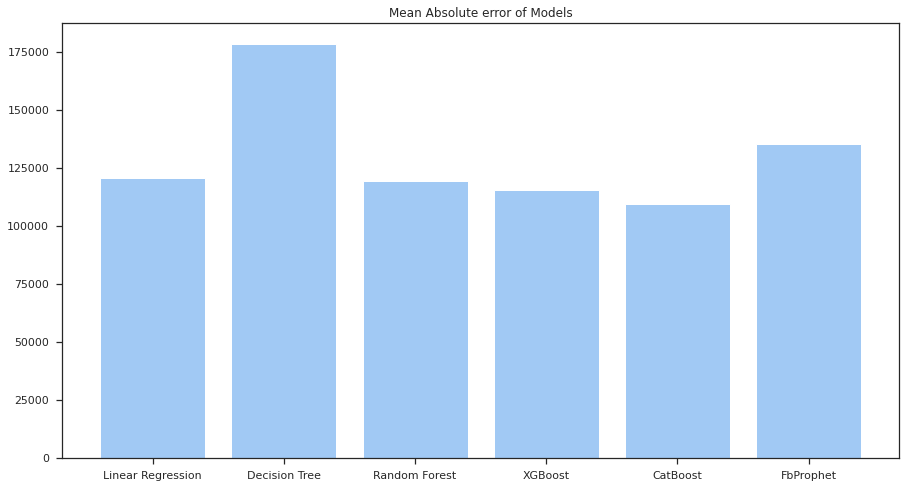

In [76]:
models_report = {
    'Linear Regression': mean_absolute_error(y_test, lr_pred),
    'Decision Tree': mean_absolute_error(y_test, dt_pred),
    'Random Forest': mean_absolute_error(y_test, rf_pred),
    'XGBoost': mean_absolute_error(y_test, xgb_pred),
    'CatBoost': mean_absolute_error(y_test, cat_pred),
    'FbProphet': mean_absolute_error(y_test, np.array(prophet_pred['yhat'])),   
}
models = list(models_report.keys())
performance = list(models_report.values())
plt.figure(figsize = (15,8))
plt.title("Mean Absolute error of Models")
plt.bar(range(len(models_report)), performance, tick_label= models)
plt.show()